In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os


In [4]:
# Set dataset path
base_dir = '/content/drive/MyDrive/sugercane-dataset/Dataset2'

# Image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

# total number of classes to 13
# tomato 10 + cane 3
NUM_CLASSES = 3

# Epochs
EPOCHS = 10


In [5]:


# Load training dataset with validation split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123,
    color_mode='rgb'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    validation_split=0.2,
    subset='validation',
    seed=123,
    color_mode='rgb'
)

# Print class names to confirm
print("Class names:", train_dataset.class_names)


Found 1164 files belonging to 3 classes.
Using 932 files for training.
Found 1164 files belonging to 3 classes.
Using 232 files for validation.
Class names: ['Normal leaf', 'Red rot', 'White leaf']


In [6]:
# Load base model with pre-trained weights
base_model = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')

# Freeze base model
base_model.trainable = False

# Build classification head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]


In [10]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9954 - loss: 0.0366

30/30 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.9954 - loss: 0.0364 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9974 - loss: 0.0258 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9977 - loss: 0.0248

30/30 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9977 - loss: 0.0249 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9915 - loss: 0.0316

30/30 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9916 - loss: 0.0313 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.9964 - loss: 0.0182 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0167

30/30 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 1.0000 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0181

30/30 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9980 - loss: 0.0146

30/30 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.9980 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - loss: 0.0123

30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.9999 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.9980 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0015


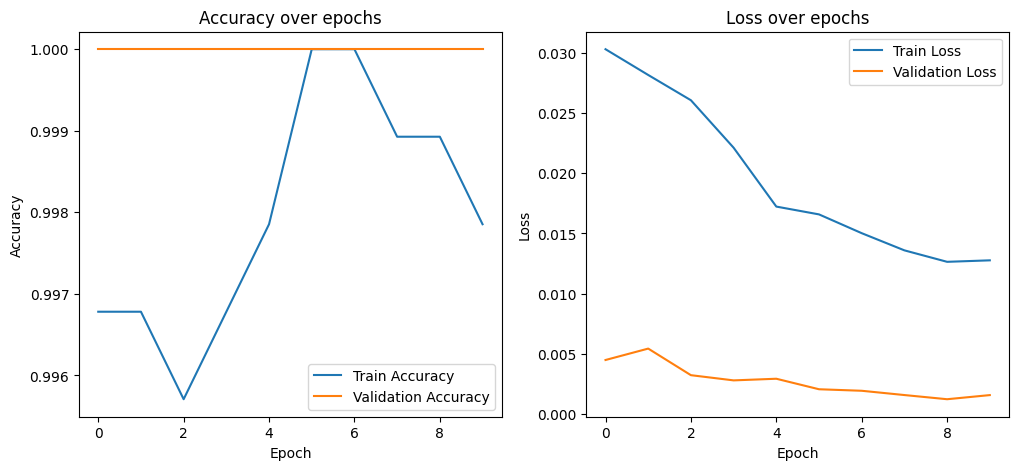

In [11]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 9.3088e-04


In [13]:
model.save('sugercane1.keras')


First, I will load the saved model.

In [15]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model('/content/drive/MyDrive/Colab Notebooks/sugercane1.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Now, I will define a function to load and preprocess the image and then make a prediction.

In [16]:
def predict_image(image_path, model, img_size=224):
    """
    Predicts the class of an image using the trained model.

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained Keras model.
        img_size (int): The target size for the image (height and width).

    Returns:
        numpy.ndarray: Predicted probabilities for each class.
    """
    img = image.load_img(image_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Rescale pixel values

    predictions = model.predict(img_array)
    return predictions

Now you can use the `predict_image` function to predict the class of your image. Replace `'path/to/your/image.jpg'` with the actual path to your image file.

In [25]:
# Example usage:
# Replace 'path/to/your/image.jpg' with the actual path to your image file
image_path = '/content/drive/MyDrive/sugercane-dataset/Dataset2/White leaf/102.jpeg'  # Replace with your image path
predictions = predict_image(image_path, model, IMG_SIZE)

# Print the predictions
print("Predictions:", predictions)

# To get the predicted class index and name
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_names = ['Normal leaf', 'Red rot', 'White leaf'] # Make sure this matches the order from your training data
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predictions: [[0.25589585 0.42013308 0.32397106]]
Predicted class index: 1
Predicted class name: Red rot
